In [18]:
import networkx as nx
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

#import community

plt.rcParams['figure.figsize'] = (25, 15)

import warnings
warnings.filterwarnings("ignore")

#### Import the Pittsburgh restaurants

In [2]:
GitHub = "https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project2/data/"

file = GitHub + "Businesses_Pittsburg.csv"

file

'https://raw.githubusercontent.com/kfolsom98/DATA620/master/Project2/data/Businesses_Pittsburg.csv'

In [3]:
file = GitHub + "Businesses_Pittsburg.csv"
business = pd.read_csv(file,  header=0, encoding="latin-1")

## 1217 business
business.shape

business.head(5)

,business_id,name,full_address,categories,city,state,review_count,neighborhoods
0,wqu7ILomIOPSduRwoWp4AQ,Denny's,"2180 Greentree Rd\r\nPittsburgh, PA 15220","c(""Breakfast & Brunch"", ""American (Traditional...",Pittsburgh,PA,7,character(0)
1,_jsJFrAmFVPRio0eEVExbA,McDonald's,4557 Ohio River Blvd\r\nBellevue\r\nPittsburgh...,"c(""Burgers"", ""Fast Food"", ""Restaurants"")",Pittsburgh,PA,4,Bellevue
2,udZJ8YgsHdqtFDQkyPTV1Q,Arby's Roast Beef Restaurants,4260 Ohio River Blvd\r\nBellevue\r\nPittsburgh...,Restaurants,Pittsburgh,PA,3,Bellevue
3,ZL6DNzyenFm9Kpz6uADlNg,Pino's Contemporary Italian Restaurant & Wine Bar,6738 Reynolds St\r\nPoint Breeze\r\nPittsburgh...,"c(""Tapas/Small Plates"", ""Restaurants"", ""Italian"")",Pittsburgh,PA,46,Point Breeze
4,OcTG-KzDleuRub-pb6JS3Q,Eddie's Pizza Haus,"1744 Chislett St\r\nMorningside\r\nPittsburgh,...","c(""Pizza"", ""Restaurants"")",Pittsburgh,PA,5,Morningside


#### Import Users

In [4]:
file = GitHub + "Users_Pittsburg.csv"
user = pd.read_csv(file,  header=0, encoding="latin-1")

## 9189 business
user.shape

#user.head(5)

(9189, 6)

#### Import Reviews which will be the basis for the edgelist

In [6]:
file = GitHub + "Reviews_Pittsburg.csv"
review = pd.read_csv(file,  header=0)

## 23339 non-distinct reviews  by user_id, business_id
review.shape

# drop the stars (rating) column
review.drop(review.columns[2],axis=1,inplace=True)

# deduplicate 
review = review.drop_duplicates()

## 22934 distinct reviews
review.shape

review.head(5)

,user_id,business_id
0,CiCmxCruMvbXtjQP5FhbLg,wqu7ILomIOPSduRwoWp4AQ
1,bbYn77XD_aAeFL-lwV7GBA,wqu7ILomIOPSduRwoWp4AQ
2,UxfFAw2-cTpeWvRROF1HEw,wqu7ILomIOPSduRwoWp4AQ
3,3eystYBQINAG1tlRBk215A,wqu7ILomIOPSduRwoWp4AQ
4,vQPRddwB2m9se3GDM05eGw,_jsJFrAmFVPRio0eEVExbA


In [7]:
#https://stackoverflow.com/questions/30850688/construct-bipartite-graph-from-columns-of-python-dataframe

G = nx.Graph()
G.add_nodes_from(business['business_id'], bipartite=0)
G.add_nodes_from(user['user_id'], bipartite=1)

G.add_edges_from([(row['business_id'], row['user_id']) for idx, row in review.iterrows()])

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10405
Number of edges: 22934
Average degree:   4.4083


In [26]:
nx.is_bipartite(G), nx.is_connected(G)

(True, False)

In [8]:
graphs = sorted(list(nx.connected_component_subgraphs(G)), key = len, reverse=True)

# take the largest subgraph; the remaining subgraphs are all with 5 nodes or less
Gsub = graphs[0]

#print(nx.info(Gsub))
#print('Network diameter =', nx.diameter(Gsub))

# network diamter = 10

In [17]:
#pos = {node:[0, i] for i,node in enumerate(business['business_id'])}
#pos.update({node:[1, i] for i,node in enumerate(user['user_id'])})
##nx.draw(G, pos, with_labels=False)
#for p in pos:  # raise text positions
#    pos[p][1] += 0.25
#nx.draw_networkx_labels(G, pos)

#plt.show()

In [31]:
#https://stackoverflow.com/questions/30998049/python-how-to-choose-what-to-print-in-a-networkx-graph
C = G.subgraph(filter(lambda x:x[1]>10, G.degree(business['business_id']).items()))

C

In [ ]:
#https://codereview.stackexchange.com/questions/57862/speed-up-projection-of-a-bipartitie-network-for-a-big-file-using-networkx-and-pa

In [9]:
users, businesses = nx.bipartite.sets(Gsub)

len(businesses), len(users)

(1046, 9146)

In [36]:
# let's check the density of the user nodes
nx.bipartite.density(Gsub, users)

0.002392775117396607

In [37]:
# let's check the density of the business nodes
nx.bipartite.density(Gsub, businesses)

0.002392775117396607

In [10]:
U = nx.bipartite.weighted_projected_graph(Gsub, users, ratio=False)

In [39]:
print(nx.info(U))

Name: 
Type: Graph
Number of nodes: 9146
Number of edges: 696786
Average degree: 152.3696


In [11]:
B = nx.bipartite.weighted_projected_graph(G, businesses, ratio=False)

In [41]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 1046
Number of edges: 85125
Average degree: 162.7629


In [12]:
# Trim edges function is taken directly from SNABook

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2


def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [46]:
## Apply Island Analysis on the women nodes
cc = list(nx.connected_component_subgraphs(U))[0]
islands = island_method(cc)

print ('Weight  Users  Groups')
for i in islands:
    print(' %d      %2d      %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Users  Groups
 1      2685      2
 7      140      2
 13      36      2
 19      17      1
 25       3      1
 31       3      1


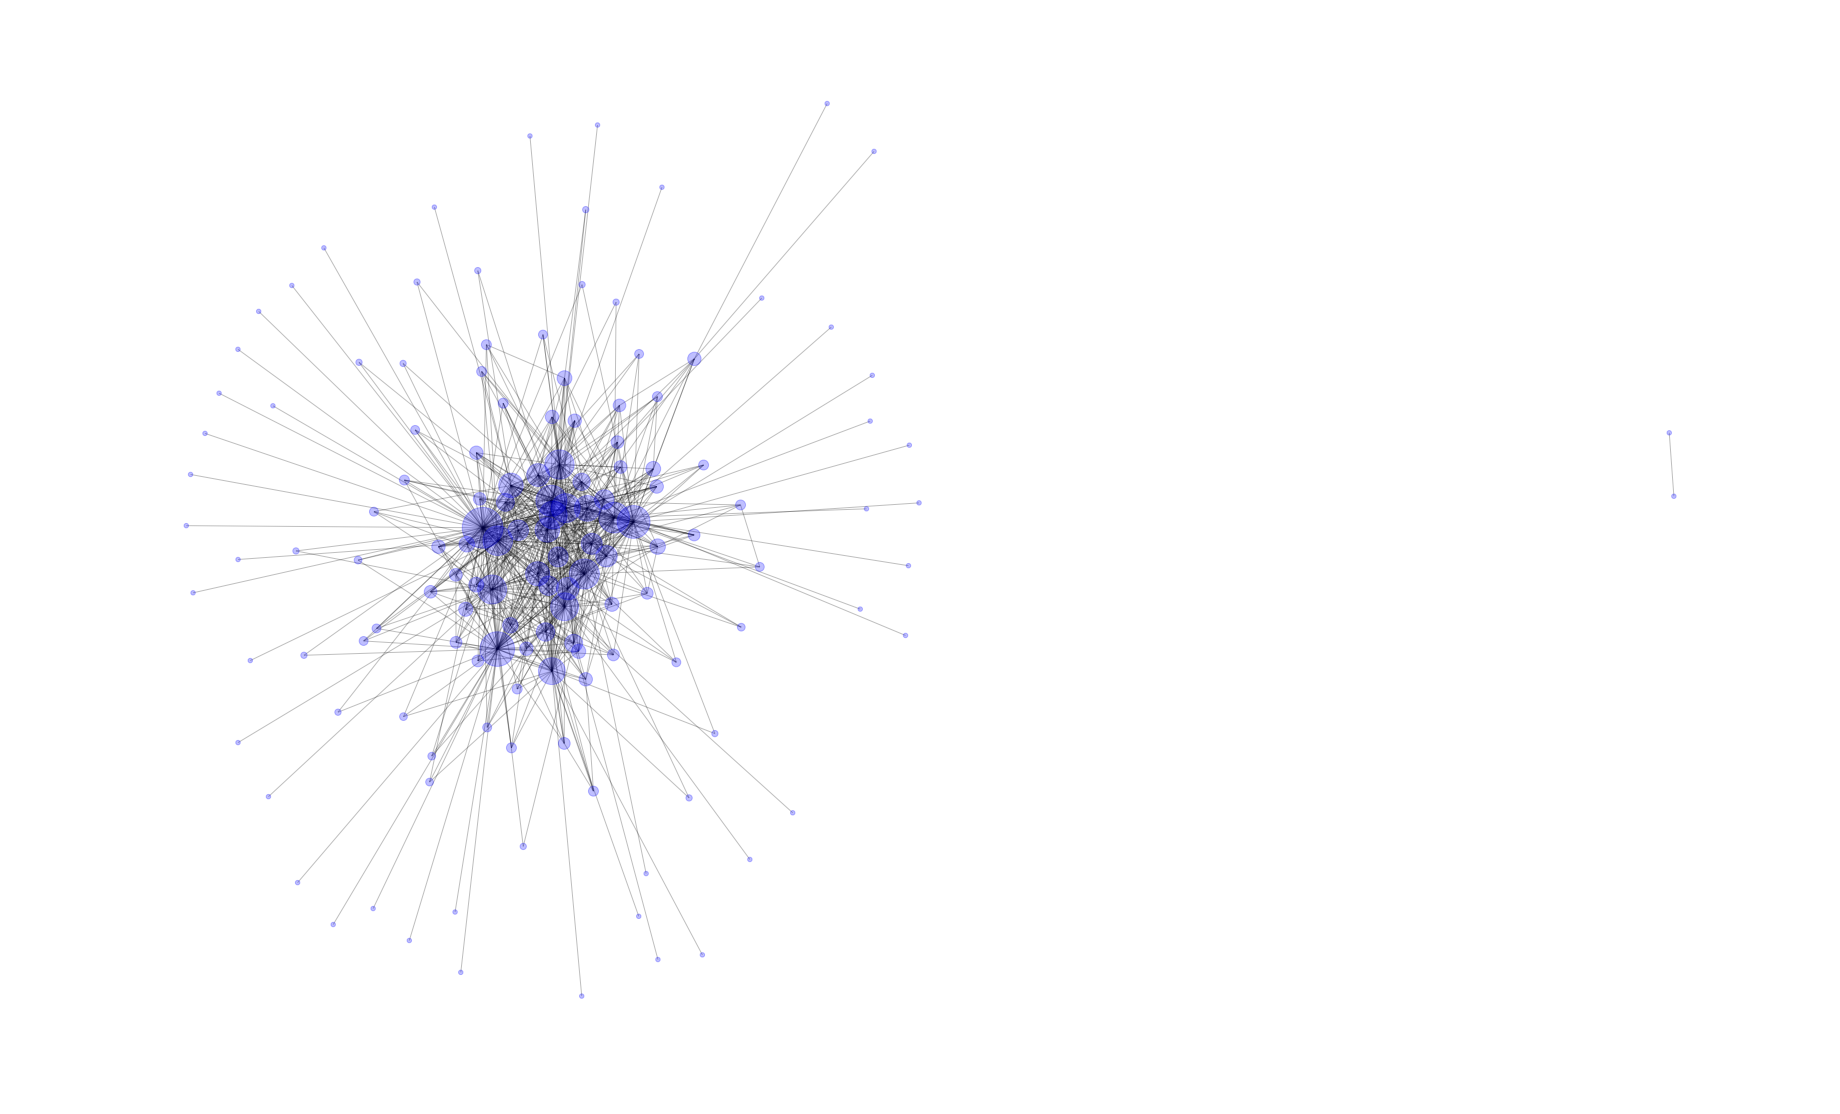

In [22]:
# apply a minimum weight 3 water level
wsub3 = trim_edges(U, 7)

spring_pos = nx.spring_layout(wsub3)
nx.draw(wsub3, spring_pos, node_size=[v*20 for v in wsub3.degree().values()], with_labels=False, node_color='b', alpha=.25, font_size=20)

In [ ]:
####
#edges = df.values.tolist()
#nodes_0 = list(set(df[‘text’].values.tolist()))
#nodes_1 = list(set(df[‘word’].values.tolist()))